# Case study: Chronic Lymphocytic Leukemia Data

This ipython notebook is an adaption of the latest notebook https://github.com/theislab/single-cell-tutorial/ (Stand 4.11.2019). Introduction parts to the main sections were also taken from this tututorial.

For the initial test run a subsample dataset was created, using only 10% of every celltype of the original data

## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#HVG>2.3 Highly variable genes</a>
    * <a href=#Visualization>2.4 Visualization</a>
  * <a href=#analysis>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#Markers>3.2 Marker genes & cluster annotation</a>

# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

from rpy2.robjects import pandas2ri

In [2]:
# parameters for better quality in regards to poster/paper graphics
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

sc.settings.figdir='../Results/figures/subsample/'
sc.settings.file_format_figs='png'
sc.settings.plot_suffix='_all_data'
sc.settings.autoshow=True

#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
#rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
#anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
%%R

# Load all the R libraries we will be using in the notebook
library(scran)

<a id="Reading"></a>

# 1. Reading in the data

In [5]:
fp = '../Data/downsampled/data.h5ad'
adata = sc.read(fp, cache=True)

In [6]:
# Checking the total size of the data set
print(adata.shape)

(4373, 22021)


<a id="Preprocessing"></a>

# 2 Pre-processing and visualization

<a id="QC"></a>

## 2.1 Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [7]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

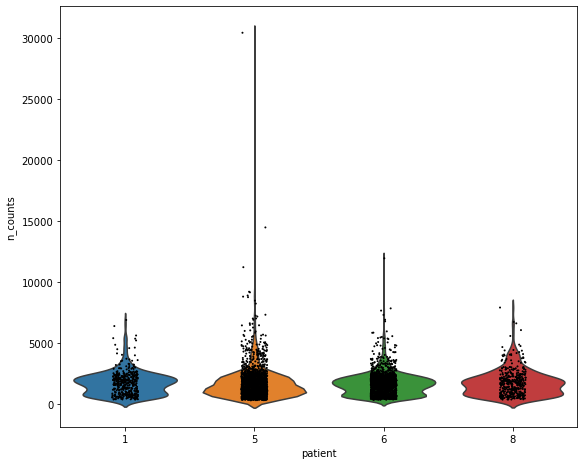

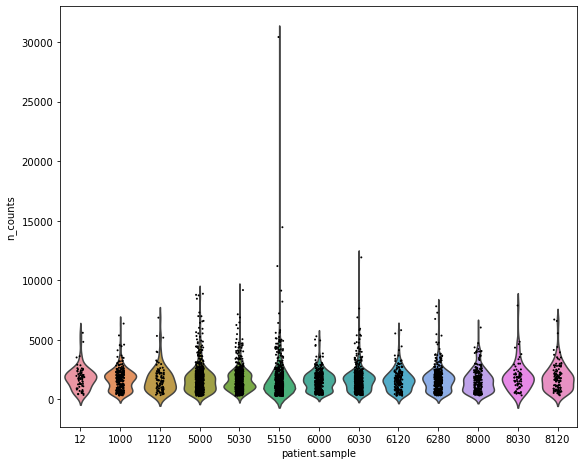

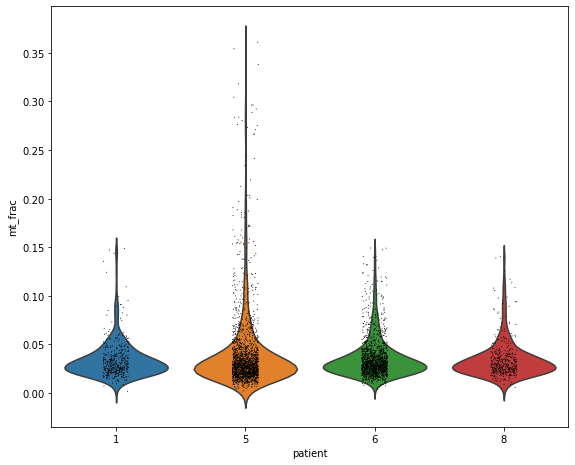

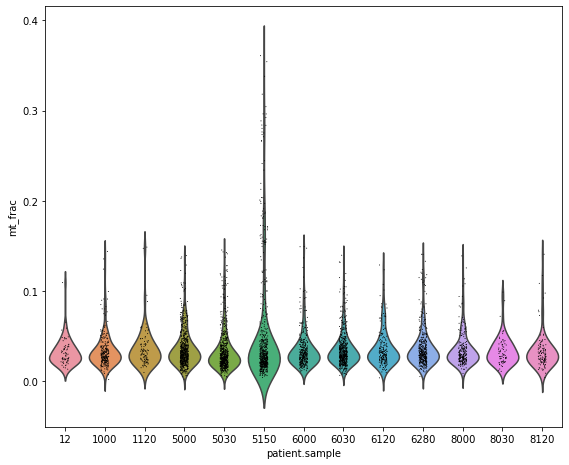

In [8]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='patient', size=2)
t2 = sc.pl.violin(adata, 'n_counts', groupby='patient.sample', size=2)
t3 = sc.pl.violin(adata, 'mt_frac', groupby='patient')
t4 = sc.pl.violin(adata, 'mt_frac', groupby='patient.sample')

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarn

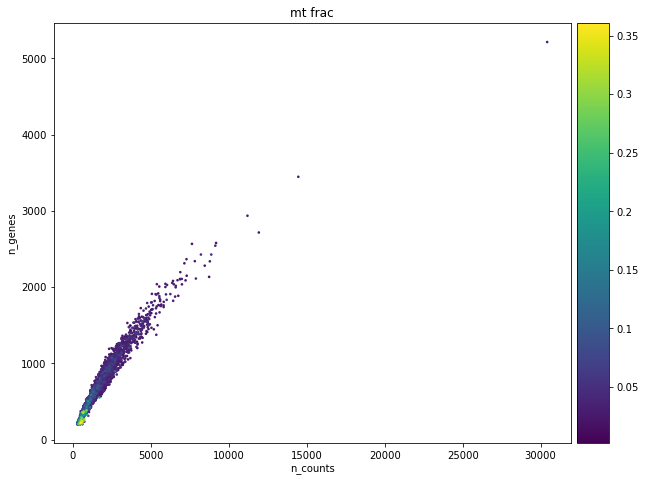

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarn

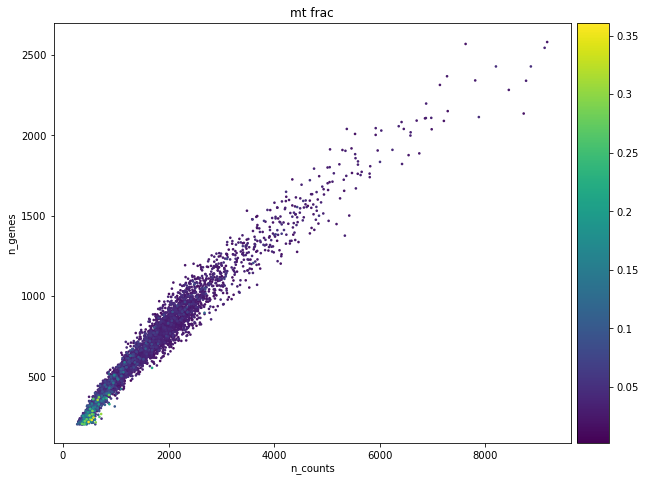

In [9]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

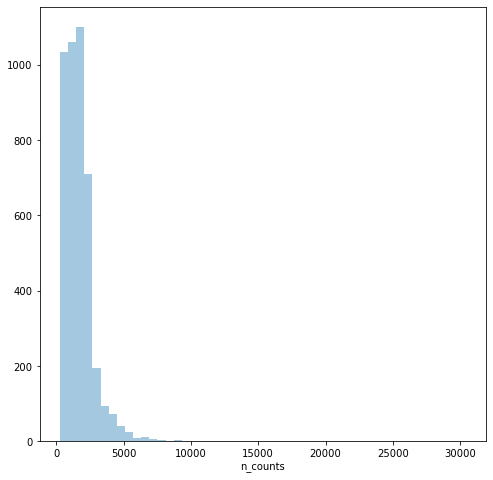

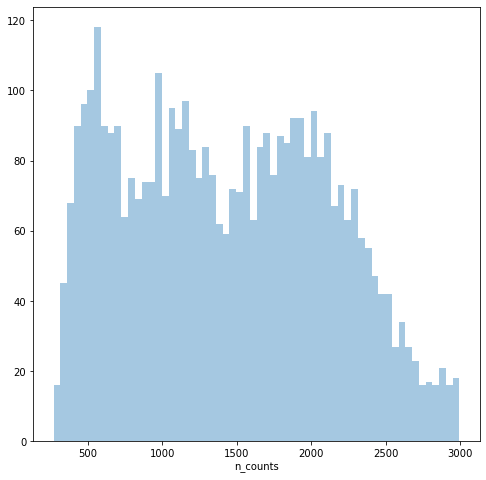

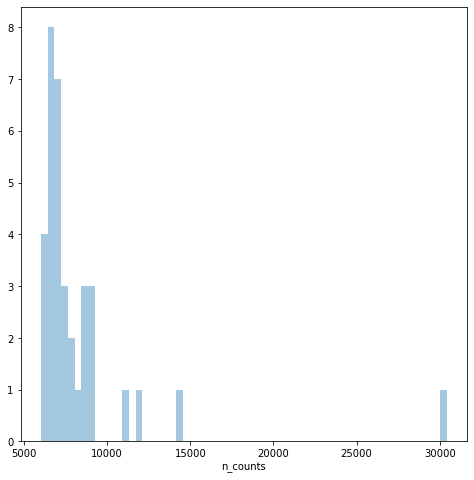

In [10]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<3000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>6000], kde=False, bins=60)
plt.show()

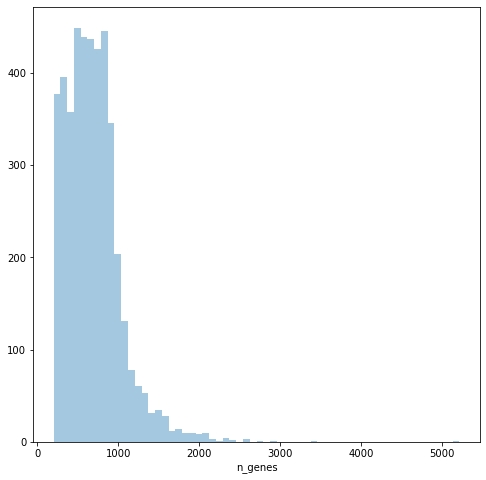

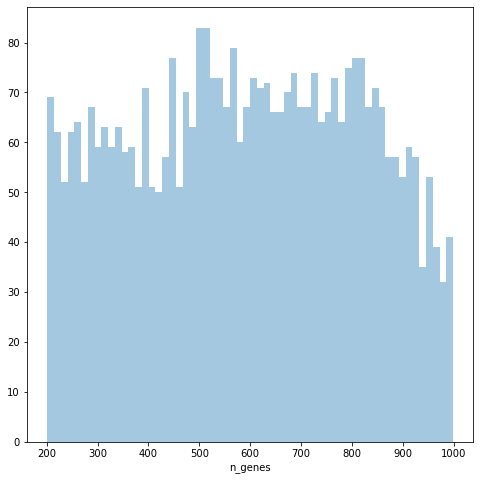

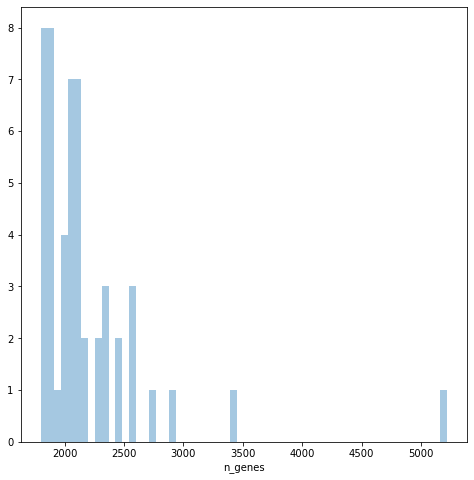

In [11]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>1800], kde=False, bins=60)
plt.show()

In [12]:
# Filtering based Rendeiro on paper
adata = adata[adata.obs['mt_frac'] < 0.15]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = 3000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Number of cells after MT filter: 4313


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 4313
filtered out 2 cells that have more than  3000 genes expressed
Number of cells after gene filter: 4311


In [13]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 22021
filtered out 11563 genes that are detected in less than 20 cells
Number of genes after cell filter: 10458


<a id="Normalization"></a>

## 2.2 Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.


In [14]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:01.01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:02.96) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.36) --> found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical)


In [15]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [16]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [17]:
#Delete adata_pp
del adata_pp

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarn

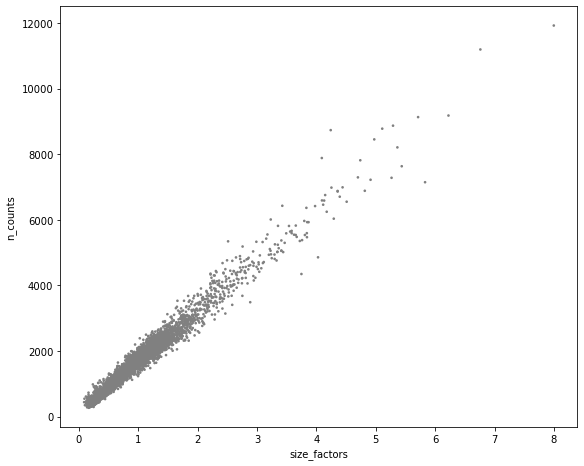

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\plotting\_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\anndata\core\anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarn

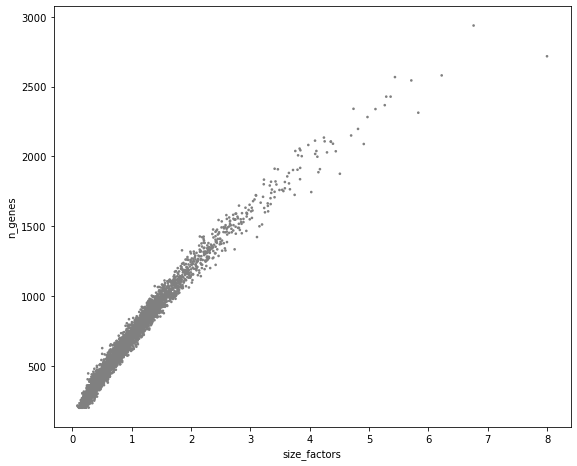

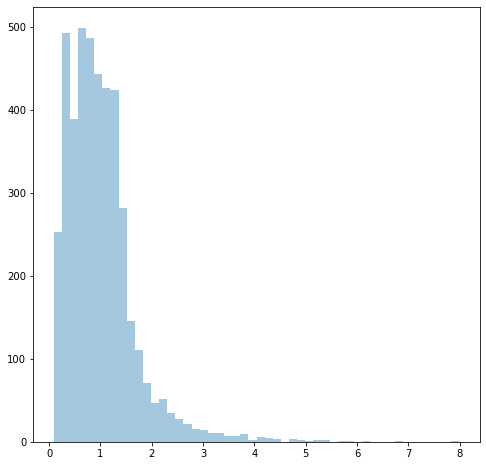

In [18]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [19]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [20]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [21]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

<a id="HVG"></a>

## 2.3 Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.


In [22]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


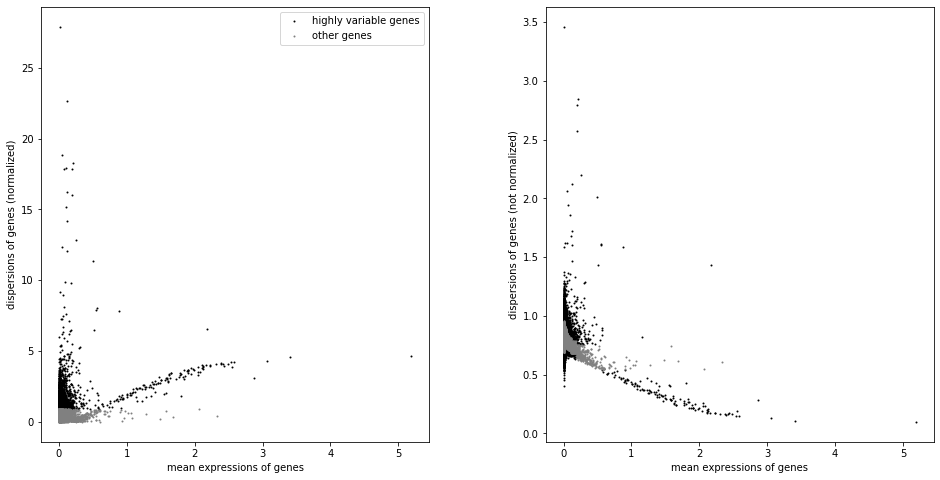

In [23]:
sc.pl.highly_variable_genes(adata)

Highly variable gene information is stored automatically in the adata.var['highly_variable'] field. The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

In [24]:
adata

AnnData object with n_obs × n_vars = 4311 × 10458 
    obs: 'sample.name', 'patient', 'cluster', 'cell_type', 'patient.sample', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'size_factors'
    var: 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'counts'

<a id="Visualization"></a>

<a id="Visualization"></a>

## 2.4 Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

In [25]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.68)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.67) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:39.40) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:07.69) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.99632347 0.9946684  0.98890483 0.98169255 0.98010707
     0.9646533  0.95627886 0.9555572  0.93271345 0.920773   0.9162595
     0.91387284 0.90581983 0.8969831 ]
    finished (0:00:00.09) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals'

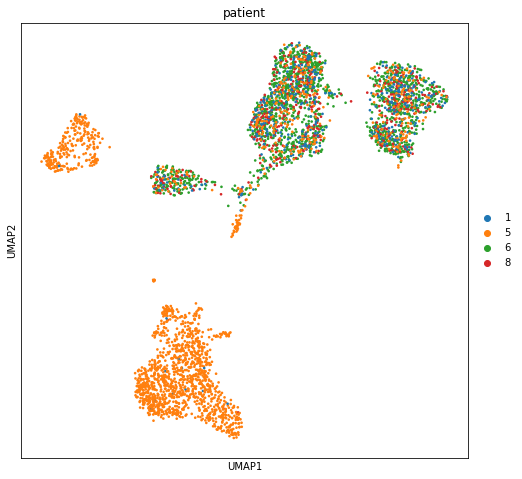

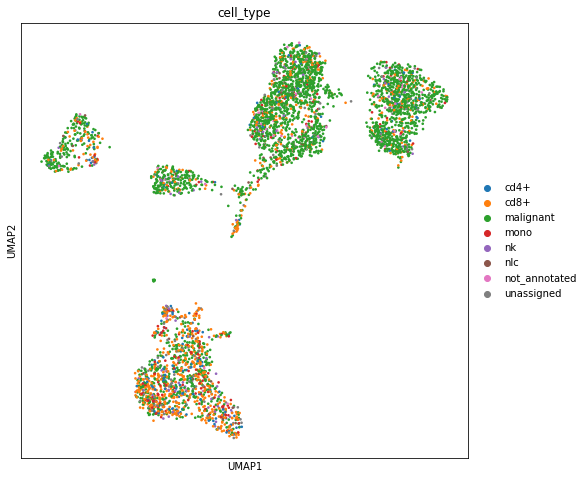

In [26]:
sc.pl.umap(adata, color='patient')
sc.pl.umap(adata, color='cell_type')

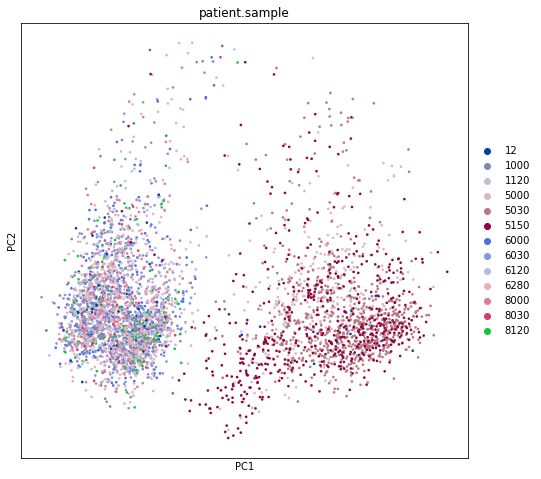

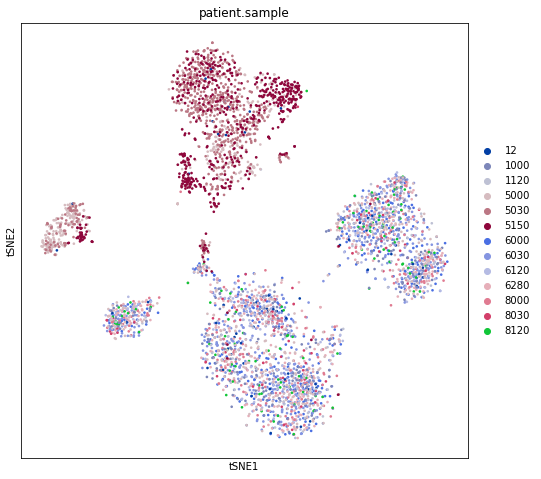

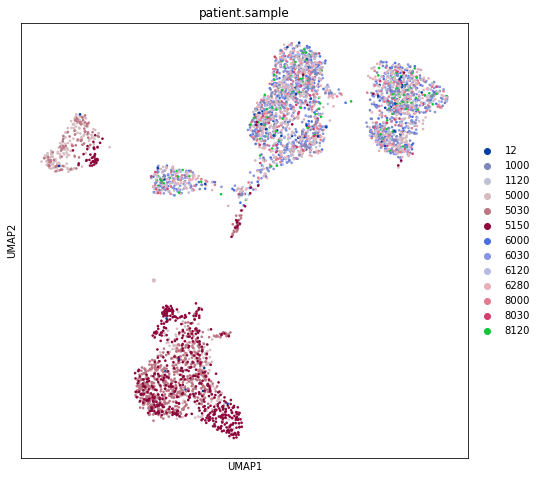

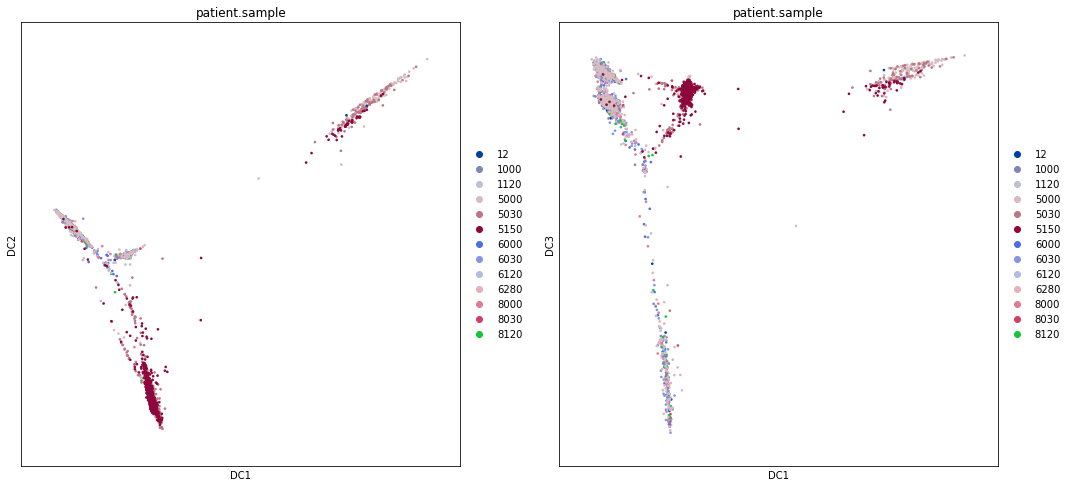

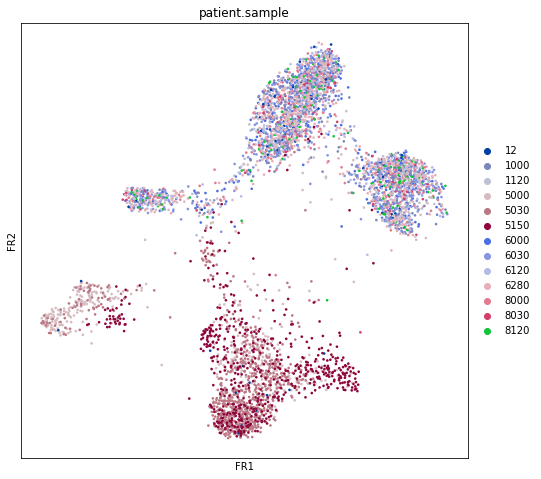

In [27]:
sc.pl.pca_scatter(adata, color='patient.sample')
sc.pl.tsne(adata, color='patient.sample')
sc.pl.umap(adata, color='patient.sample')
sc.pl.diffmap(adata, color='patient.sample', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='patient.sample')

In [28]:
adata.obs['cell_type'].value_counts()

malignant        2725
cd8+              807
mono              214
unassigned        187
cd4+              173
nk                 99
not_annotated      67
nlc                39
Name: cell_type, dtype: int64

<a id="analysis"></a>

# 3 Downstream analysis

<a id="Clustering"></a>

## 3.1 Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section.


In [29]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10) # random state = 10 from original tutorial for graphic consistency

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.39) --> found 12 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.39) --> found 6 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)


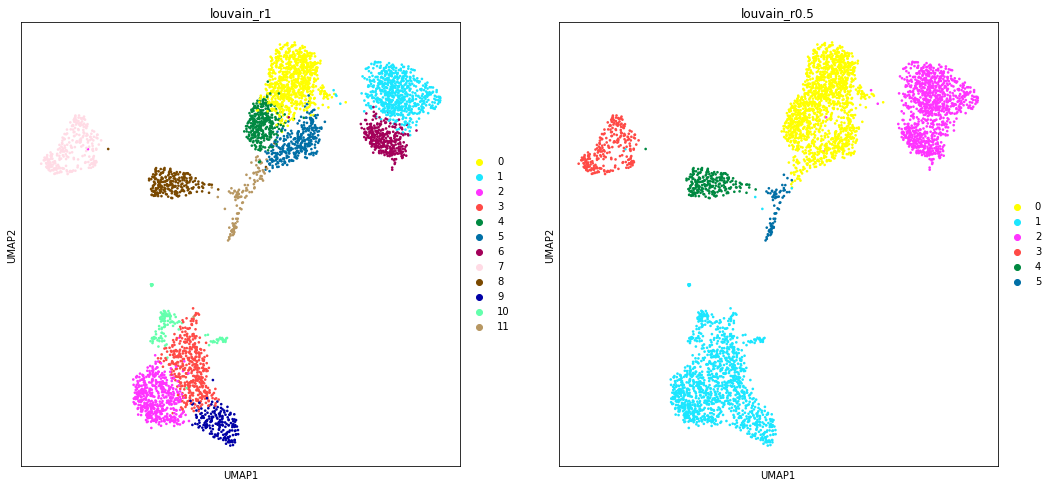

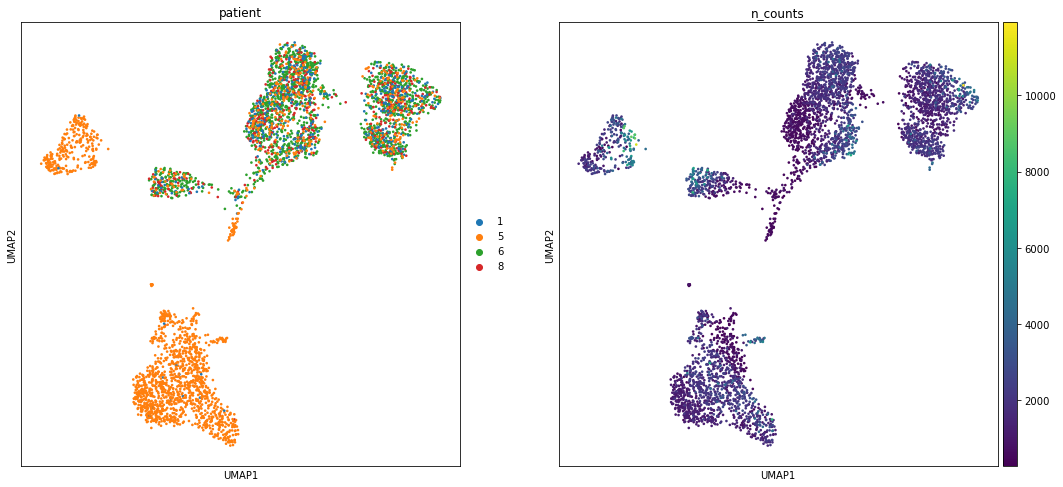

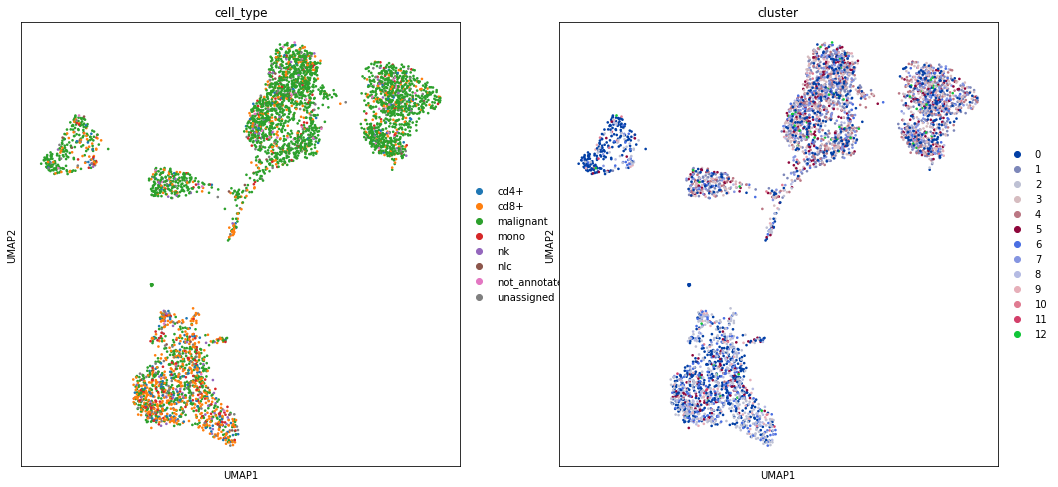

In [30]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['patient', 'n_counts'])
sc.pl.umap(adata, color=['cell_type', 'cluster'])

<a id="Marker"></a>

## 3.2 Marker genes & cluster annotation

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

As we are using the relevant mouse gut atlas from the literature in this case study, there is no other reference atlas which we use to annotate the cells by automated annotation. Thus, we do not use scmap or garnett here.

[Timing: 25.1s]

In [31]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:01.46) --> added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


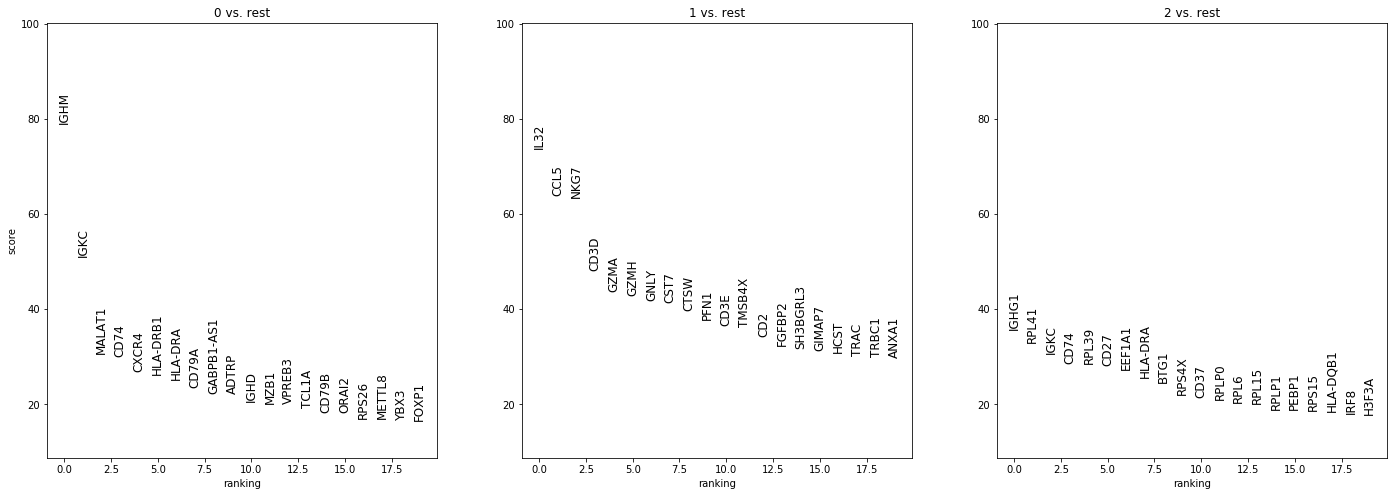

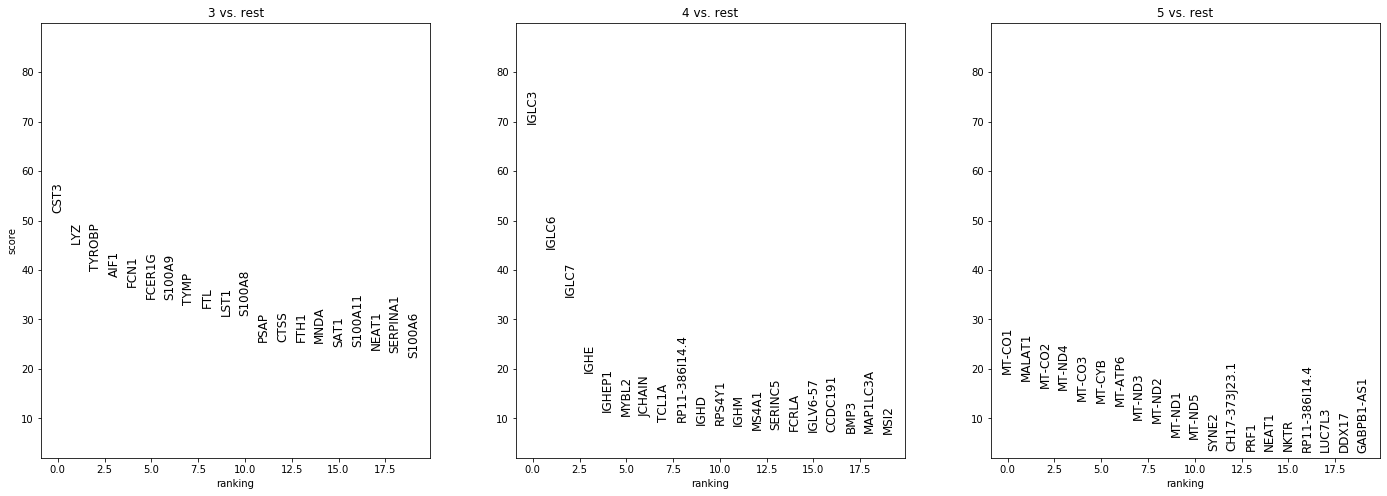

In [32]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['0', '1', '2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['3', '4', '5'], fontsize=12)

### Cell-Marker-Lists

#### CellMarker

##### all marker:
marker_genes["cancer"] = ["MCAM", "ABCB5", "CD271", "EpCAM", "MCSP", "MITF", "MLANA", "OCT3/4", "PMEL", "SALL4", "TYR", "WFDC2"]
marker_genes["cd8+"] = ["CD8A", "CD8B", "CD3D", "CD4", "CD8", "GZMK", "NKG7"]
marker_genes["cd4+"] = ["CD4", "CTLA4", "FOXP3", "GLUT1", "IL2RA", "LTB"]
marker_genes["nk"] = ["CD16", "CD3", "CD45", "CD56", "CD8A", "CD8B", "Granzyme", "NK1.1", "ZNF683"]
marker_genes["nkt"] = ["CD56", "CD16", "KLRB1", "NKG7", "CCL3", "CD160", "CD247", "CD3", "CD3D", "CD45", "CD49a", "CXCR6", "FCGR3A", "FCGR3B", "GNLY", "GZMB", "ID2", "KLRC1", "KLRD1", "KLRF1", "KLRK1", "NCAM1", "NKG2A", "NKG2D"]
marker_genes["monocyte"] = ["CD14", "CD16", "CD11b", "HLA-DR", "CD11c", "CD123", "CD15", "CD3", "CD33", "CD66b", "CD19", "CD56", "CD20", "CD27", "CD38", "B7H1", "CCR7", "CD117", "CD126", "CD138", "CD142", "CD158a", "CD158b", "CD161", "CD2", "CD203c", "CD22", "CD32", "CD4", "CD40", "CD45", "CD45RA", "CD49a", "CD49b", "CD57", "CD62L", "CD64", "CD68", "CD8", "CD80", "CD86", "CD94", "CXCR6", "IgA", "IgG", "NKG2A", "NKG2C", "NKp46", "PD-1", "S100A12", "TCRvalpha24", "TCRvbeta11", "TNFR2"]


marker_genes["B"] = ["CD19", "CD27", "IgD", "CD38", "CD138", "CD24", "CD45", "CD5", "CD79A", "IgM", "BLNK", "CD117", "CD1d", "CD20", "CD21", "CD229", "CD319", "CD37", "CD54", "CD56", "CD74", "CD79B", "Leu-12", "MS4A1", "TAGLN2", "ZAP70"]

marker_genes["cancer-stem"] = ["CD44", "EpCAM", "IL1RAP"]

marker_genes["dendric"] = ["CD11c", "CD123", "CD11b", "CD14", "CD15", "CD16", "CD33", "CD66b", "CD83", "CD86", "HLA-DR", "CD1C", "CD80", "CLEC4C", "CST3", "FCER1A", "GZMB", "IL3RA", "MHC class II", "NRP1"]

marker_genes["endothelial"] = ["CD133", "CD34", "CD45", "CD144", "CD31", "CDH5", "SELE", "VWF"]

marker_genes["fibroblast"] = ["COL1A1", "COL3A1", "FAP", "THY1"]

marker_genes["granulocyte"] = ["CD15", "CD203c", "CD11b", "CD16", "CD63", "CD66b", "CD123", "CD14", "CD11c", "CD33", "HLA-DR", "CD49d", "CD69", "CCR3", "CD117", "CD193", "CD44", "CD45", "FMLP", "GP110", "IL-13", "IL-3R-alpha", "IL-4", "IL-5", "IL-5R-alpha", "IL-8", "SIGLEC8"]

marker_genes["macrophage"] = ["CD14", "CD163", "C-type lectin-like receptor dectin-1", "CCR7", "CD127", "CD16", "CD184", "CD206", "CD209", "CD23", "CD32", "CD36", "CD62", "CD64", "CD68", "CD80", "CD86", "CLACSF13", "CSF1R", "CXCL10", "DCIR", "FCGR3A", "FIZZ1", "IL-1", "IL-15R", "IL-17R", "IL-1R-1", "IL-2R", "LYZ", "M60", "TLR2", "TLR4", "TRAIL"]

marker_genes["megacaryocyte"] = ["CD41a", "CD34", "CD42a", "CD61", "PF4"]

##### sc-seq only marker:

marker_genes['B'] = ['CD19', 'CD79A', 'BLNK', 'CD37', 'CD79B', 'MS4A1']

marker_genes["cancer"] = ["MCAM", "EpCAM", "MITF", "MLANA", "PMEL", "TYR", "WFDC2"]

marker_genes["dentritic"] = ["CLEC4C", "IL3RA", "NRP1"]
#monocyte derived dendritic cell
marker_genes["monodend"] = ["CD1C", "CST3", "FCER1A"]
#plasmacytoid dendritic cell
marker_genes["plasdend"] = ["CD123", "GZMB"]

marker_genes["endothelial"] = ["CDH5", "SELE", "VWF"]

marker_genes["fibroblast"] = ["COL1A1", "COL3A1", "FAP", "THY1"]

marker_genes["macrophage"] = ["CD14", "CD163", "CD68", "CSF1R", "FCGR3A"]

#CD14+CD16+ monocyte
marker_genes["monocyte"] = ["CD14", "CD16", "CD68", "S100A12"]

marker_genes["nk"] = ['CCL3', 'CD160', 'CD247', 'GNLY', 'GZMB', 'NKG7', 'FCGR3A', 'FCGR3B', 'KLRB1', 'KLRB1', 'KLRC1', 'KLRD1', 'KLRF1', 'KLRK1', 'NCAM1', 'ID2']

#(Megakaryocyte)Progenitor cell
marker_genes["megaprog"] = ['PF4', 'PLA2G12A', 'PPBP']

#Naive T cell
marker_genes["TN"] = ['CCR7', 'CD27', 'CD8A', 'CD8B']
marker_genes["T"] = ['CD27', 'CD28', 'CD3D', 'CD3E', 'CD3G']
#Naive CD4+ T cell
marker_genes["cd4+N"] = ['ABLIM1', 'ACTN1', 'C1orf162', 'C6orf48', 'CCR7', 'CD55', 'EEF1B2', 'EIF3L', 'FAM117B', 'FHIT', 'GIMAP5', 'GIMAP8', 'GPR183', 'IL7R', 'LDLRAP1', 'LRRC75A-AS1', 'LRRN3', 'MAL', 'MYC', 'NELL'2,' NOSIP', 'PRKCA', 'RPS5', 'RSL1D1', 'SATB1', 'SERINC5', 'SLC40A1', 'SVIL', 'TCF7', 'TESPA1', 'TMEM204', 'TRABD2A', 'TSHZ2', 'TXK']
#CD4+ memory T cell
marker_genes["cd4+M"] = ['CCR7', 'CD27', 'IL7R']
marker_genes["cd4+"] = ["CD4", "CTLA4", "FOXP3", "IL2RA"]
#Naive CD8+ T cell
marker_genes["cd8+N"] = ['ABLIM1', 'ACTN1', 'AIF1', 'APBA2', 'APEX1', 'ARHGAP45', 'ARHGEF18', 'ATM', 'BACH2', 'BEX4', 'C1orf162', 'C1orf228', 'C6orf48', 'CA6', 'CAMK4', 'CCR7', 'CD248', 'CD55', 'CEP68', 'COQ8A', 'DGKA', 'EEF2', 'EIF3E', 'EIF3L', 'EPHX2', 'EXOSC8', 'FAM102A', 'FAM117B', 'FAM60A', 'FKBP5', 'FOXP1', 'GAS5', 'GCSAM', 'GIMAP2', 'GLTSCR2', 'GPR155', 'GPR183', 'IGF1R', 'ITFG2', 'LDHB', 'LDLRAP1', 'LEF1', 'LEF1-AS1', 'LINC01550', 'LMO7', 'LRRC75A', 'LRRC75A-AS1', 'LRRN3', 'MAL', 'MAML2', 'MLXIP', 'MYC', 'NDFIP1', 'NELL2', 'NOG', 'NOSIP', 'NPAT', 'NPM1', 'NT5E', 'OXNAD1', 'PASK', 'PDE3B', 'PDK1', 'PIK3IP1', 'PLEKHB1', 'PRKCQ-AS1', 'PSIP1', 'R3HDM4', 'RACK1', 'RASGRP2', 'RCAN3', 'RIC3', 'RPS8', 'SCML4', 'SELL', 'SERINC5', 'SGSM3', 'SH3YL1', 'SMAP2', 'SNED1', 'SNURF', 'SPINT2', 'SPTBN1', 'STMN3', 'TCF7', 'THAP7', 'THEM4', 'TMEM123', 'TMEM204', 'TMEM63A', 'TNFSF8', 'TOMM7', 'TPCN1', 'TRABD2A', 'TRAP1', 'TRMT1', 'TXK', 'UBQLN2', 'VIPR1', 'WDR43', 'ZNF101']

marker_genes["cd8+"] = ["CD8A", "CD8B", "CD4", "GZMK"]
marker_genes["nkt"] = ['CD8A', 'CD8B', 'ZNF683']
#Regulatory T (Treg) cell
marker_genes['treg1'] = ['CCR10', 'CD25', 'CD52', 'CMTM7', 'FOXP3', 'CD4', 'CTLA4', 'FOXP3', 'IL2RA']
marker_genes['treg2'] = ['ANXA2P2', 'ATP2B1', 'B3GNT2', 'BIRC3', 'CASP2', 'CCDC141', 'CCM2', 'CCR10', 'CCR4', 'CCR8', 'CLDND1', 'CORO7', 'CORO7-PAM16', 'CPNE'2,' ELK3', 'F5', 'FAM110A', 'FANK1', 'FCMR', 'FCRL3', 'FOXP3', 'GLRX', 'HAPLN3', 'HPGD', 'IKZF2', 'IL10RA', 'IL2RA', 'ISG20', 'LMNA', 'METTL7A', 'PDP1', 'PI16', 'REREP3', 'RNF214', 'RTKN2', 'SAMHD1', 'SELPLG', 'SNX20', 'STAM', 'TBC1D4', 'TLDC2', 'TRIM16', 'TTC39C', 'TTN', 'USP15']



In [33]:
adata.obs['cell_type'].value_counts()

malignant        2725
cd8+              807
mono              214
unassigned        187
cd4+              173
nk                 99
not_annotated      67
nlc                39
Name: cell_type, dtype: int64

NLC = nurselike cells

In [34]:
#Known marker genes:
marker_genes = dict()

marker_genes['up'] = []
marker_genes["cancer"] = ["MCAM", "EpCAM", "MITF", "MLANA", "PMEL", "TYR", "WFDC2"]
marker_genes["endothelial"] = ["CDH5", "SELE", "VWF"]

#CD14+CD16+ monocyte
marker_genes["monocyte"] = ["CD14", "CD16", "CD68", "S100A12"]
marker_genes["nk"] = ['CCL3', 'CD160', 'CD247', 'GNLY', 'GZMB', 'NKG7', 'FCGR3A', 'FCGR3B', 'KLRB1', 'KLRB1', 'KLRC1', 'KLRD1', 'KLRF1', 'KLRK1', 'NCAM1', 'ID2']

# (Megakaryocyte)Progenitor cell
marker_genes["megaprog"] = ['PF4', 'PLA2G12A', 'PPBP']
marker_genes["T"] = ['CD27', 'CD28', 'CD3D', 'CD3E', 'CD3G']
marker_genes["cd4+"] = ["CD4", "CTLA4", "FOXP3", "IL2RA"]
marker_genes["cd8+"] = ["CD8A", "CD8B", "CD4", "GZMK"]
marker_genes["nkt"] = ['CD8A', 'CD8B', 'ZNF683']
marker_genes['down'] = []

In [35]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5')
cell_annotation

,0,1,2,3,4,5
up,0.0,0.0,0.0,0.0,0.0,0.0
cancer,0.0,0.0,0.0,0.0,0.0,0.0
endothelial,0.0,0.0,0.0,0.0,0.0,0.0
monocyte,0.0,0.0,0.0,3.0,0.0,0.0
nk,0.0,7.0,0.0,1.0,0.0,1.0
megaprog,0.0,0.0,0.0,0.0,0.0,0.0
T,0.0,3.0,1.0,0.0,0.0,0.0
cd4+,0.0,0.0,0.0,0.0,0.0,0.0
cd8+,0.0,3.0,0.0,0.0,0.0,0.0
nkt,0.0,3.0,0.0,0.0,0.0,0.0


We can also visualize the marker gene overlap as a fraction of the total marker genes, and then plot this as a heatmap for simpler cell identity annotation.

C:\Users\Bobi\Anaconda3\envs\sc-tutorial\lib\site-packages\scanpy\tools\_marker_gene_overlap.py:236: RuntimeWarning: invalid value encountered in true_divide
  marker_match = marker_match/ref_lengths[:,np.newaxis]


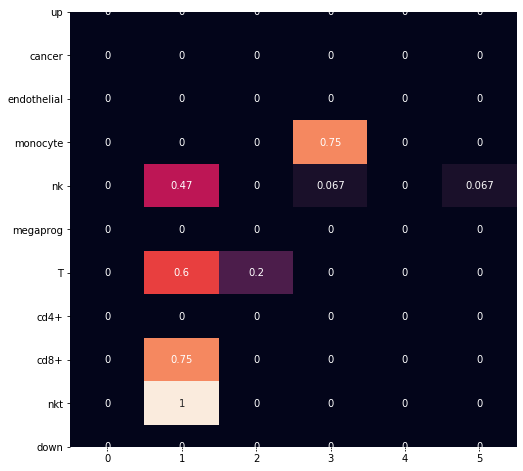

In [36]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [37]:
for celltype in set(adata.obs['cell_type']):
    print(celltype)
    print(adata.obs[adata.obs['cell_type']==celltype]['louvain_r0.5'].value_counts()/adata.obs['louvain_r0.5'].value_counts())

unassigned
0    0.036810
1    0.058685
2    0.036660
3    0.042308
4    0.032389
5    0.038961
Name: louvain_r0.5, dtype: float64
nlc
0    0.011588
1    0.007825
2    0.004073
3    0.019231
4    0.004049
5    0.025974
Name: louvain_r0.5, dtype: float64
cd8+
0    0.109066
1    0.346635
2    0.108961
3    0.161538
4    0.117409
5    0.337662
Name: louvain_r0.5, dtype: float64
nk
0    0.015678
1    0.039124
2    0.013238
3    0.011538
4    0.036437
5    0.012987
Name: louvain_r0.5, dtype: float64
cd4+
0    0.012952
1    0.082942
2    0.026477
3    0.050000
4    0.028340
5    0.025974
Name: louvain_r0.5, dtype: float64
malignant
0    0.755965
1    0.371674
2    0.757637
3    0.673077
4    0.728745
5    0.545455
Name: louvain_r0.5, dtype: float64
not_annotated
0    0.021813
1    0.008607
2    0.018330
3    0.007692
4    0.016194
5    0.000000
Name: louvain_r0.5, dtype: float64
mono
0    0.036128
1    0.084507
2    0.034623
3    0.034615
4    0.036437
5    0.012987
Name: louvain_r0.5, dtype:

In [38]:
#Categories to rename
adata.obs['louvain_r0.5'].cat.categories

Index(['0', '1', '2', '3', '4', '5'], dtype='object')

In [39]:
adata.rename_categories('louvain_r0.5', ['-', 'nkt', 'T', 'mono', '--', 'nk'])

In [40]:
adata.obs['louvain_r0.5'].value_counts()

-       1467
nkt     1278
T        982
mono     260
--       247
nk        77
Name: louvain_r0.5, dtype: int64

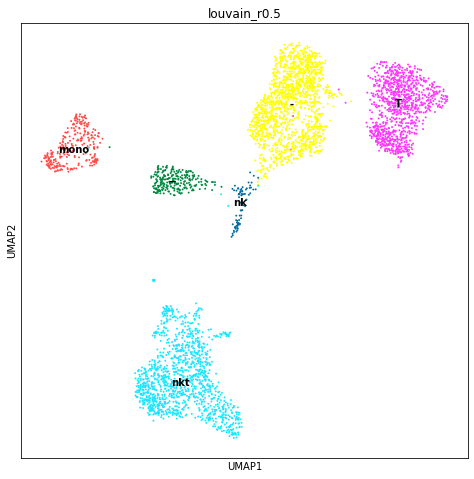

In [41]:
sc.pl.umap(adata, color='louvain_r0.5', size=15, legend_loc='on data')

As CellMarker Database does not provide markers comparable to the malignant celltype label from Rendeiro and these profiles dominate the data, we decided to exclude profiles with malignant celltype label for all data for better comparability.

Visualization plots suggest that the data is already batch corrected and cell cycle scored. Further these steps of preprocessing have to be handled carefully due mixing of natural vs technical variance in the data.
We decided not to do any further batch correction or cell cycle scoring on the provided data.